In [1]:
#%%
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import pmdarima as pm
# import logging as log
from pmdarima. import auto_arima
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tools.eval_measures import rmse
from sklearn.metrics import mean_squared_error,mean_absolute_error, mean_absolute_percentage_error
from math import sqrt
# from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
# from sklearn.ensemble import RandomForestRegressor
import warnings
warnings.filterwarnings("ignore")

In [2]:
#%%

# Configure logging to print to standard output
log.basicConfig(level=log.INFO, format='%(message)s')

In [3]:
#%%

# Load data from csv file
data = pd.read_csv('Modified_Data.csv', index_col=[0], parse_dates=True)
data.head()

,Price
2002-01-01,19.96
2002-02-01,20.19
2002-03-01,24.03
2002-04-01,26.03
2002-05-01,25.69


In [4]:
#%%

# Plot data
fig = px.line(data, x=data.index, y='Price', title='Close Price')
fig.show()

In [5]:
#%%

# set the train and test data with start dates
train_start_date = '2002-01-01'
test_start_date = '2019-01-01'

In [51]:
#%%

# set the train and test data and print the dimensions of it
train = data.copy()[(data.index >= train_start_date) & (data.index < test_start_date)][['Price']]
test = data.copy()[data.index >= test_start_date][['Price']]

print('Training data shape: ', train.shape)
print('Test data shape: ', test.shape)

--- Logging error ---
Traceback (most recent call last):
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.10_3.10.3056.0_x64__qbz5n2kfra8p0\lib\logging\__init__.py", line 1100, in emit
    msg = self.format(record)
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.10_3.10.3056.0_x64__qbz5n2kfra8p0\lib\logging\__init__.py", line 943, in format
    return fmt.format(record)
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.10_3.10.3056.0_x64__qbz5n2kfra8p0\lib\logging\__init__.py", line 678, in format
    record.message = record.getMessage()
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.10_3.10.3056.0_x64__qbz5n2kfra8p0\lib\logging\__init__.py", line 368, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.10_3.10.3056.0_x64__qbz5n2kfra8p0\lib\runpy.py", line 196, in 

In [7]:
#%%

# Plot train and test splits
fig = go.Figure()
fig.add_trace(go.Scatter(x=train.index, y=train['Price'], mode='lines', name='Train'))
fig.add_trace(go.Scatter(x=test.index, y=test['Price'], mode='lines', name='Test'))
fig.update_layout(title='Train and Test Split', xaxis_title='Date', yaxis_title='Price')
fig.show()

In [8]:
#%%

# Convert data to series
series = pd.Series(data=train['Price'].to_numpy(), index =train.index)

In [9]:
#%%

def adf_test(series):
    result = adfuller(series)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])

adf_test(series)

ADF Statistic: -2.502675
p-value: 0.114825


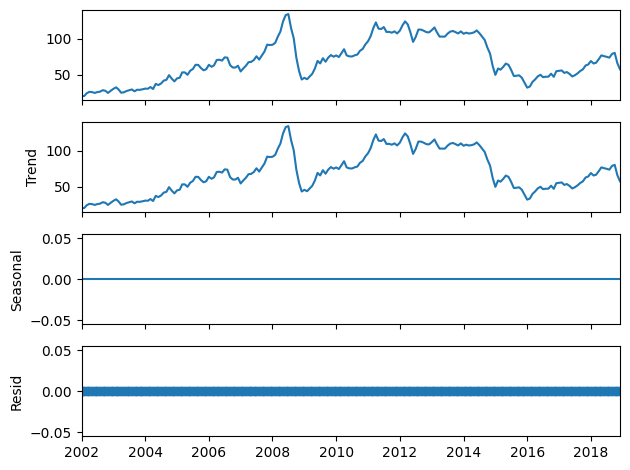

In [10]:
#%%

# Decompose time series into trend, seasonal, and residual components
result = seasonal_decompose(series, model='additive', period=1)
result.plot()
plt.show()

In [11]:
#%%

# Differencing to make the series stationary and plot the differenced series
diff = series.diff(periods=1).dropna()
diff_2 = diff.diff(periods=1).dropna()

# plot and add legend in top right corner with plotly subplots
fig = make_subplots(rows=3, cols=1)
fig.add_trace(go.Scatter(x=diff.index, y=diff, name='1st Difference'), row=1, col=1)
fig.add_trace(go.Scatter(x=diff_2.index, y=diff_2, name='2nd Difference'), row=2, col=1)
fig.add_trace(go.Scatter(x=series.index, y=series, name='Original'), row=3, col=1)
fig.show()

In [12]:
#%%

# number of  differencing for stationary series with ndiffs
from pmdarima.arima.utils import ndiffs
y = series
# Adf Test
print('ADF:', ndiffs(y, test='adf'))
# KPSS test
print('KPSS:', ndiffs(y, test='kpss'))
# PP test:
print('PP:', ndiffs(y, test='pp'))

ADF: 1
KPSS: 1
PP: 1


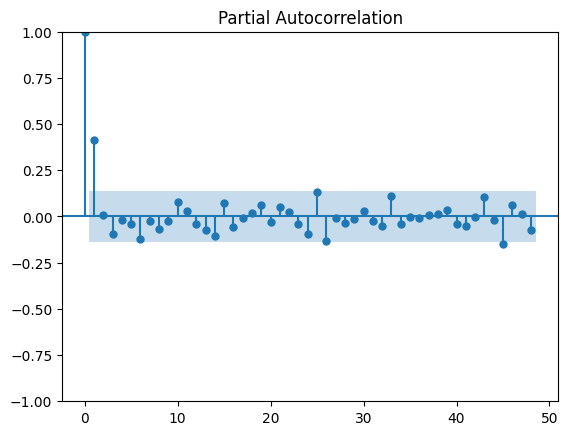

In [13]:
#%%

# Order of auto regressive term P
plot_pacf(diff, lags =48).show()

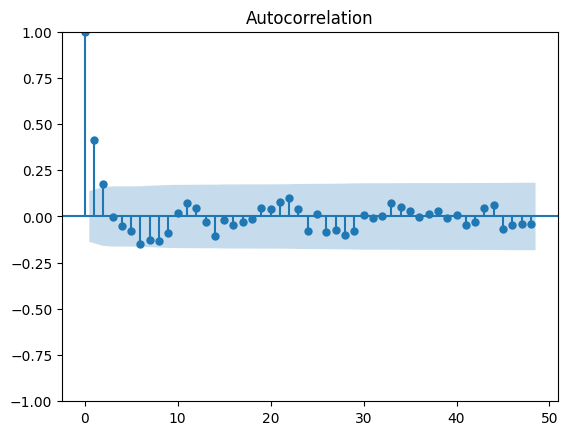

In [14]:
#%%

# Find order of MA term Q
plot_acf(diff, lags=48).show()

In [39]:
#%%

# use auto_arima to find best parameters
model = pm.auto_arima(train, seasonal=True, stepwise=True, suppress_warnings=True, trace=True, error_action="ignore")

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1256.629, Time=0.36 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1290.891, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1254.825, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1262.100, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1289.102, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1256.781, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1256.796, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1258.338, Time=0.11 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=1252.888, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=1254.840, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=1254.855, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=1260.226, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=1256.393, Time=0.06 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 0.887 seconds


In [40]:
#%%

order = model.order 

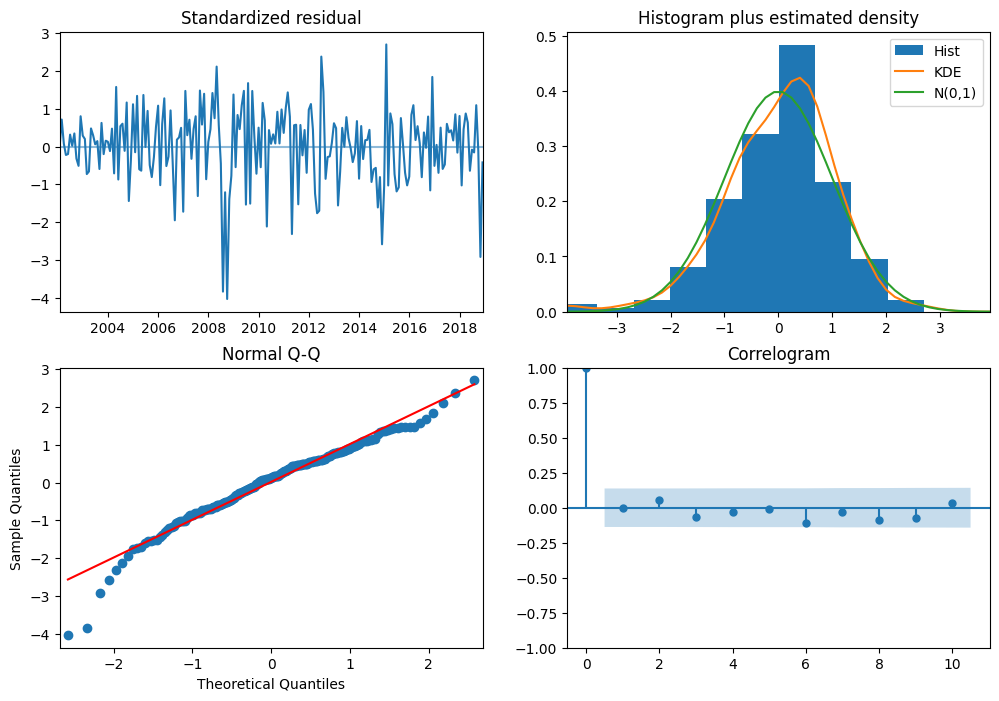

In [41]:
#%%

model.plot_diagnostics(figsize=(12, 8)).show()

In [43]:
#%%
# Fit the model with the rraining set and best parameters found by auto_arima 
model = SARIMAX(train, order= order)
model_fit = model.fit()

In [46]:
model_fit.summary(alpha=0.05)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Price   No. Observations:                  204
Model:               SARIMAX(1, 1, 0)   Log Likelihood                -624.444
Date:                Mon, 13 May 2024   AIC                           1252.888
Time:                        16:30:00   BIC                           1259.514
Sample:                    01-01-2002   HQIC                          1255.568
                         - 12-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4152      0.047      8.894      0.000       0.324       0.507
sigma2        27.4768      2.023     13.585      0.000      23.513      31.441
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                45.36
Prob(Q):                              0.95   Prob(JB):                         0.00
Heteroskedasticity (H):               1.38   Skew:                            -0.74
Prob(H) (two-sided):                  0.19   Kurtosis:                         4.78
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [47]:
model_fit.summary(alpha=0.10)

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Price   No. Observations:                  204
Model:               SARIMAX(1, 1, 0)   Log Likelihood                -624.444
Date:                Mon, 13 May 2024   AIC                           1252.888
Time:                        16:30:42   BIC                           1259.514
Sample:                    01-01-2002   HQIC                          1255.568
                         - 12-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|       [0.05       0.95]
------------------------------------------------------------------------------
ar.L1          0.4152      0.047      8.894      0.000       0.338       0.492
sigma2        27.4768      2.023     13.585      0.000      24.150      30.804
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                45.36
Prob(Q):                              0.95   Prob(JB):                         0.00
Heteroskedasticity (H):               1.38   Skew:                            -0.74
Prob(H) (two-sided):                  0.19   Kurtosis:                         4.78
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [30]:
# dynamic=False means that forecasts at each point are generated using the full history up to that point
predictions = model_fit.predict(start=test.index[0], end=test.index[-1], dynamic=False)

In [34]:
#%%

# Calculate evaluation metrics
# Root Mean Squared Error (RMSE)
rmse = sqrt(mean_squared_error(test['Price'], predictions))
print(f'RMSE: {rmse:.3f}')

# Mean Absolute Error (MAE)
mae = mean_absolute_error(test['Price'], predictions)
print(f'MAE: {mae:.3f}')

# Mean Absolute Percentage Error (MAPE)
mape = mean_absolute_percentage_error(test['Price'], predictions)
print(f'MAPE: {mape*100:.3f}%')

#%%
# Plot actual vs predicted with plotly
fig = go.Figure()
fig.add_trace(go.Scatter(x=test.index, y=test['Price'], mode='lines', name='Actual'))
fig.add_trace(go.Scatter(x=test.index, y=predictions, mode='lines', name='Predicted'))
fig.update_layout(title='Actual vs Predicted Prices', xaxis_title='Date', yaxis_title='Price')
fig.show()



RMSE: 27.743
MAE: 22.322
MAPE: 30.476%


In [ ]:
# Forecast for 24 months from 2023-01-01
future_dates = pd.date_range(start='2023-01-01', periods=24, freq='M')

# 95% confidence interval
forecast_obj_95 = model_fit.get_prediction(start=future_dates[0], end=future_dates[-1])
forecast_95 = forecast_obj_95.predicted_mean
conf_int_95 = forecast_obj_95.conf_int(alpha=0.05)

# 90% confidence interval
forecast_obj_90 = model_fit.get_prediction(start=future_dates[0], end=future_dates[-1])
conf_int_90 = forecast_obj_90.conf_int(alpha=0.10)

# Plot actual data, forecast, and confidence intervals
fig = go.Figure()
fig.add_trace(go.Scatter(x=data.index, y=data['Price'], mode='lines', name='Actual'))
fig.add_trace(go.Scatter(x=future_dates, y=forecast_95, mode='lines', name='Forecast'))

# 95% confidence interval
fig.add_trace(go.Scatter(x=future_dates, y=conf_int_95.iloc[:, 0], mode='lines', name='Lower 95% CI', line=dict(color='rgba(255,0,0,0.5)')))
fig.add_trace(go.Scatter(x=future_dates, y=conf_int_95.iloc[:, 1], mode='lines', name='Upper 95% CI', line=dict(color='rgba(255,0,0,0.5)'), fill='tonexty'))

# 90% confidence interval
fig.add_trace(go.Scatter(x=future_dates, y=conf_int_90.iloc[:, 0], mode='lines', name='Lower 90% CI', line=dict(color='rgba(0,0,255,0.5)')))
fig.add_trace(go.Scatter(x=future_dates, y=conf_int_90.iloc[:, 1], mode='lines', name='Upper 90% CI', line=dict(color='rgba(0,0,255,0.5)'), fill='tonexty'))

fig.update_layout(title='Brent Crude Oil Price Forecast (with Confidence Intervals)', xaxis_title='Date', yaxis_title='Price')
fig.show()

In [35]:
print(conf_int)


            lower Price  upper Price
2023-02-01   -70.935909   174.502284
2023-03-01   -72.187203   175.753579
2023-04-01   -73.425993   176.992369
2023-05-01   -74.652646   178.219022
2023-06-01   -75.867512   179.433888
2023-07-01   -77.070925   180.637301
2023-08-01   -78.263202   181.829578
2023-09-01   -79.444647   183.011023
2023-10-01   -80.615550   184.181926
2023-11-01   -81.776188   185.342564
2023-12-01   -82.926827   186.493203
2024-01-01   -84.067721   187.634096
2024-02-01   -85.199112   188.765488
2024-03-01   -86.321235   189.887611
2024-04-01   -87.434314   191.000690
2024-05-01   -88.538564   192.104939
2024-06-01   -89.634191   193.200567
2024-07-01   -90.721395   194.287771
2024-08-01   -91.800368   195.366743
2024-09-01   -92.871292   196.437668
2024-10-01   -93.934346   197.500722
2024-11-01   -94.989701   198.556076
2024-12-01   -96.037521   199.603897
2025-01-01   -97.077966   200.644342
